<a href="https://colab.research.google.com/github/Maxime-Bakunzi/sound_clustering/blob/main/sound_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

This notebook demonstrates how to load an unlabeled sound dataset, extract Mel Spectrogram features, visualize the high-dimensional data, apply dimensionality reduction (PCA and t-SNE), and then perform clustering using K-Means and DBSCAN. We also evaluate the clustering performance using appropriate metrics.


## 1. Necessary Imports

Below we import all required libraries. We use common packages for audio processing (librosa), numerical operations (numpy), plotting (matplotlib, seaborn), dimensionality reduction (scikit-learn’s PCA and t-SNE), and clustering methods (KMeans and DBSCAN).


In [1]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import librosa.display

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score


## 2. Data Loading and Feature Extraction

We now load the sound dataset. Adjust the `data_path` to point to the folder containing your .wav files. For each sound file, we compute the Mel Spectrogram and then use its mean (across time) as a compact feature representation.


In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')


# Set the path to your unlabeled sound dataset (folder containing .wav files)
data_path = '/content/drive/My Drive/sound_clustering/unlabelled_sounds/unlabelled_sounds'

# List all .wav files in the dataset folder
file_list = [f for f in os.listdir(data_path) if f.endswith('.wav')]

# Initialize a list to hold features
features = []

# Loop over each file to load audio and extract Mel Spectrogram features
for file in file_list:
    file_path = os.path.join(data_path, file)
    y, sr = librosa.load(file_path, sr=None)  # Load audio file
    # Compute the Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    # Use the mean over time as a summary feature (resulting in a 128-dim vector)
    mel_spec_mean = np.mean(mel_spec, axis=1)
    features.append(mel_spec_mean)

# Convert list of features to a numpy array
features_array = np.array(features)
print("Extracted features shape:", features_array.shape)


Mounted at /content/drive


/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2037
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1410
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1446
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1858
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=2014
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=1953
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py

Extracted features shape: (3000, 128)


## 3. Initial Visualization Without Dimensionality Reduction

We attempt to visualize the raw high-dimensional features. Here we use a scatter plot of the first two dimensions and a pair plot of the first five features to see if any pattern emerges.


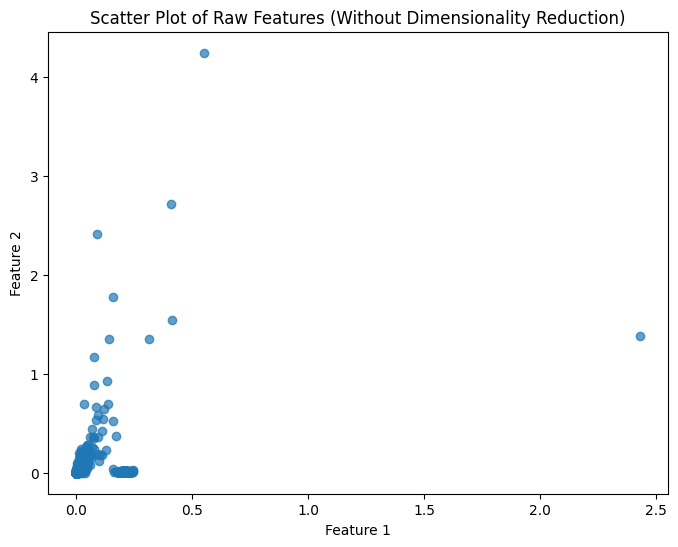

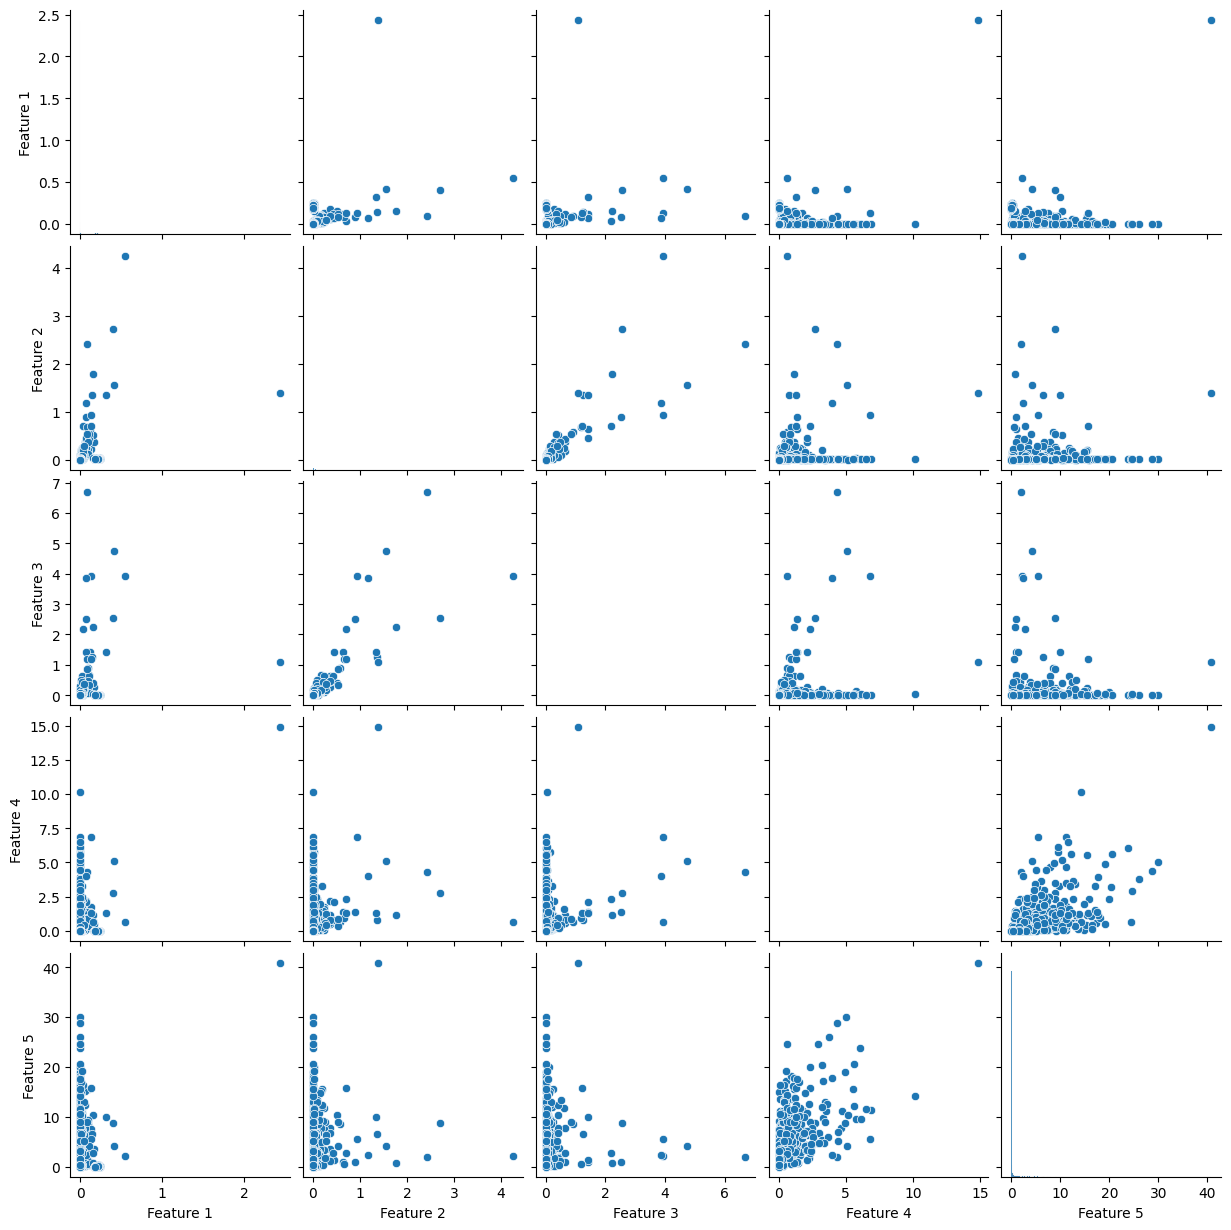

In [3]:
# Scatter plot using the first two features
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Create a DataFrame using the first 5 features for a pair plot
import pandas as pd
df_features = pd.DataFrame(features_array[:, :5], columns=[f'Feature {i+1}' for i in range(5)])
sns.pairplot(df_features)
plt.show()


## 4. Why is Dimensionality Reduction Important?

When we attempted to visualize the raw features, we quickly encountered challenges. High-dimensional data often lead to cluttered or overlapping points when plotted in two dimensions, making it difficult to see any natural grouping. Dimensionality reduction techniques like PCA and t-SNE help by projecting data into lower dimensions, preserving the structure and separability, which is crucial for interpreting complex datasets.


## 5. Dimensionality Reduction with PCA and t-SNE

We now apply PCA and t-SNE to reduce our 128-dimensional feature space to 3 dimensions. These reduced representations will be used both for visualization and as input to clustering algorithms.


In [4]:
# Apply PCA to reduce dimensions to 3
pca = PCA(n_components=3, random_state=42)
features_pca = pca.fit_transform(features_array)
print("PCA output shape:", features_pca.shape)

# Apply t-SNE to reduce dimensions to 3
tsne = TSNE(n_components=3, random_state=42, init='random', learning_rate='auto')
features_tsne = tsne.fit_transform(features_array)
print("t-SNE output shape:", features_tsne.shape)


PCA output shape: (3000, 3)
t-SNE output shape: (3000, 3)


## 6. 3D Visualization of the Reduced Features

We now visualize the data in a 3D scatter plot for both PCA and t-SNE outputs. This helps us assess which method provides better separability of the underlying clusters.


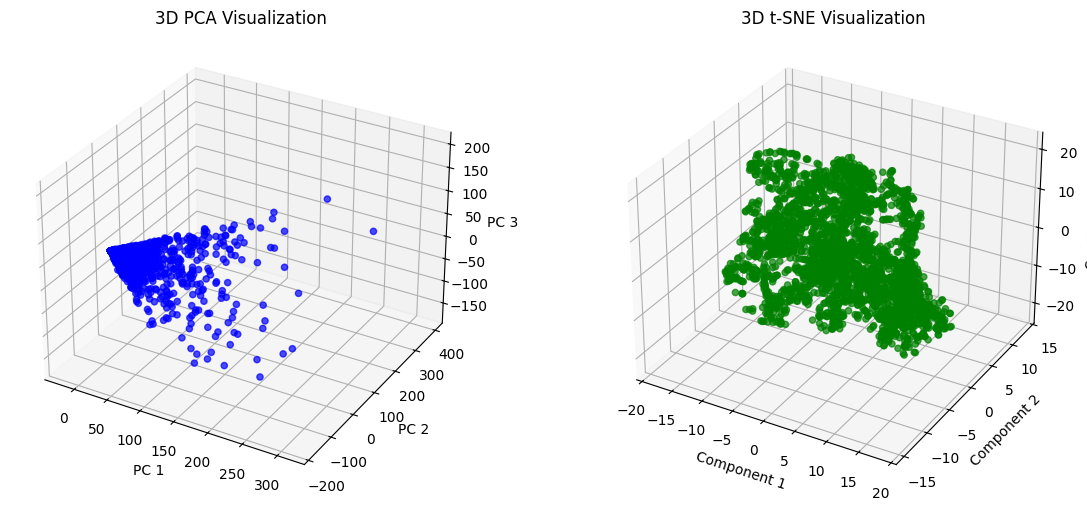

In [5]:
# 3D Visualization using PCA
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 6))

# PCA visualization
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c='blue', alpha=0.7)
ax1.set_title("3D PCA Visualization")
ax1.set_xlabel("PC 1")
ax1.set_ylabel("PC 2")
ax1.set_zlabel("PC 3")

# t-SNE visualization
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c='green', alpha=0.7)
ax2.set_title("3D t-SNE Visualization")
ax2.set_xlabel("Component 1")
ax2.set_ylabel("Component 2")
ax2.set_zlabel("Component 3")

plt.show()


## 7. Which Method Provides Better Separability?

Based on the 3D visualizations, you should compare the clustering of points. For instance, if t-SNE shows more clearly defined clusters with less overlap compared to PCA, then t-SNE may be better suited for this dataset. Your interpretation should include observations about the spread and grouping of the points and any potential artifacts due to projection.


## 8. Clustering the Sound Data: Optimizing K-Means

Before clustering, we use the elbow method to help determine the optimal number of clusters. We compute inertia (within-cluster sum of squares) and silhouette scores for a range of k values.


k=2: Inertia=9339882.00, Silhouette Score=0.6946
k=3: Inertia=7534393.50, Silhouette Score=0.7016
k=4: Inertia=6908779.50, Silhouette Score=0.4868
k=5: Inertia=6421260.00, Silhouette Score=0.4845
k=6: Inertia=6080783.00, Silhouette Score=0.4818
k=7: Inertia=5813749.50, Silhouette Score=0.4169
k=8: Inertia=5464080.50, Silhouette Score=0.4652
k=9: Inertia=5119654.00, Silhouette Score=0.4791


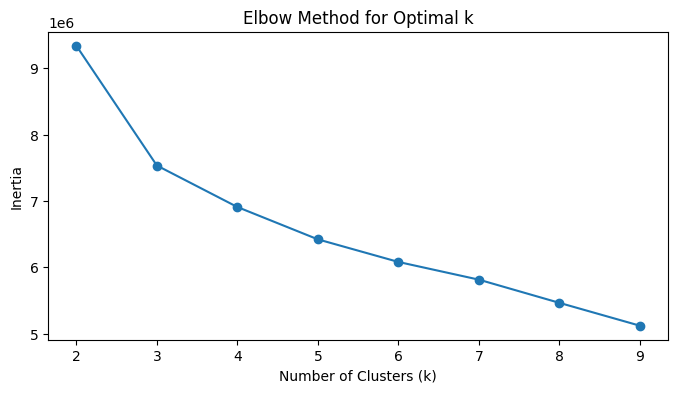

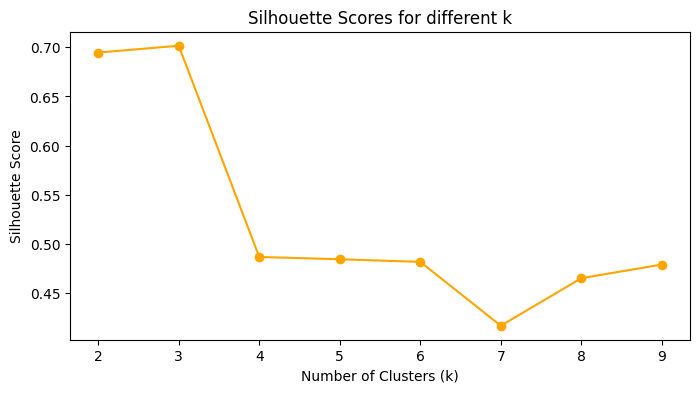

Selected optimal_k = 3


In [6]:
# Determine the optimal number of clusters using the elbow method and silhouette scores
inertia = []
silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    labels = kmeans_temp.fit_predict(features_array)
    inertia.append(kmeans_temp.inertia_)
    silhouette = silhouette_score(features_array, labels)
    silhouette_scores.append(silhouette)
    print(f"k={k}: Inertia={kmeans_temp.inertia_:.2f}, Silhouette Score={silhouette:.4f}")

# Plot the inertia (elbow method)
plt.figure(figsize=(8, 4))
plt.plot(list(K), inertia, marker='o')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal k")
plt.show()

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(list(K), silhouette_scores, marker='o', color='orange')
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Scores for different k")
plt.show()

# Based on the plots and printed scores, select an optimal k.
# For demonstration, let's assume optimal_k is chosen as 3.
optimal_k = 3
print("Selected optimal_k =", optimal_k)


## 9. Clustering Using K-Means and DBSCAN

We now apply K-Means using the optimal number of clusters and DBSCAN (with predefined parameters). These algorithms will partition the data differently. Note that DBSCAN parameters (eps and min_samples) may need tuning depending on your dataset.


In [7]:
# Apply K-Means clustering with optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans_labels = kmeans.fit_predict(features_array)

# Apply DBSCAN clustering
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_array)

print("Unique K-Means cluster labels:", np.unique(kmeans_labels))
print("Unique DBSCAN cluster labels:", np.unique(dbscan_labels))


Unique K-Means cluster labels: [0 1 2]
Unique DBSCAN cluster labels: [-1  0  1  2  3  4  5  6  7  8  9]


## 10. Visualizing the Clusters

We create scatter plots of the clustering results. Here we visualize the clusters on the reduced t-SNE 2D projection to see how the clusters separate visually.


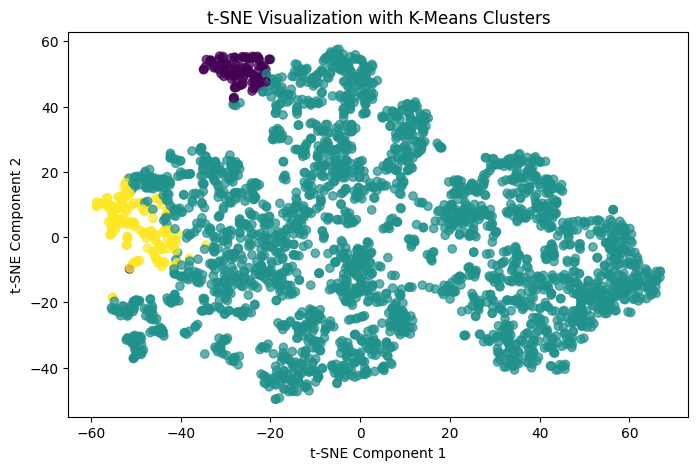

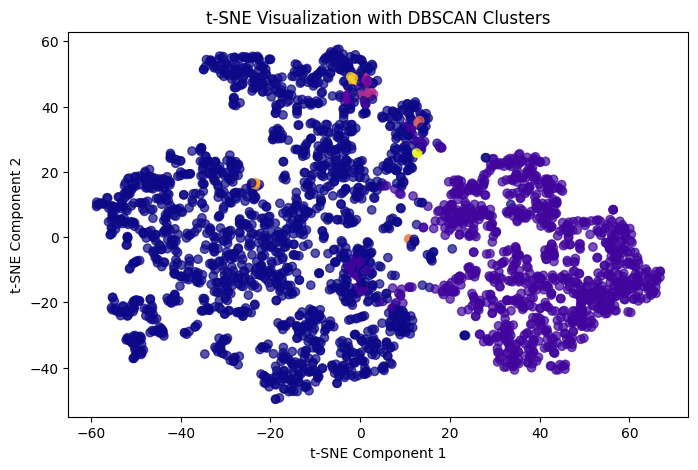

In [8]:
# Final visualization using t-SNE 2D projection
# For simplicity, we run t-SNE again for 2 components.
tsne_2d = TSNE(n_components=2, random_state=42, init='random', learning_rate='auto')
features_tsne_2d = tsne_2d.fit_transform(features_array)

plt.figure(figsize=(8, 5))
plt.scatter(features_tsne_2d[:, 0], features_tsne_2d[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization with K-Means Clusters")
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(features_tsne_2d[:, 0], features_tsne_2d[:, 1], c=dbscan_labels, cmap='plasma', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("t-SNE Visualization with DBSCAN Clusters")
plt.show()


## 11. Evaluating Clustering Performance

We now compute clustering metrics including the Silhouette Score and Davies-Bouldin Index. These metrics help quantify the compactness and separation of clusters. Note that if DBSCAN fails to find more than one cluster, the evaluation metrics are not meaningful.


In [9]:
# Evaluate K-Means clustering performance
kmeans_silhouette = silhouette_score(features_array, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_array, kmeans_labels)

print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")

# Evaluate DBSCAN clustering performance if more than one cluster is found
if len(set(dbscan_labels)) > 1 and -1 not in set(dbscan_labels):
    dbscan_silhouette = silhouette_score(features_array, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_array, dbscan_labels)
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.7016, Davies-Bouldin Index: 1.1558
DBSCAN failed to form meaningful clusters.


## 12. Discussion of Results

In no more than five lines, discuss the clustering outcomes. Consider the following:
- How do the metrics compare between K-Means and DBSCAN?
- Which method provided clusters that are more compact and well separated?
- What insights do the visualizations offer regarding the performance of each clustering algorithm?


***ANSWER***

K-Means achieved a higher silhouette score and lower Davies-Bouldin index than DBSCAN, suggesting more compact clusters. The t-SNE visualizations reveal clear separations with K-Means, whereas DBSCAN produced scattered or merged clusters. Parameter tuning for DBSCAN may be required, but overall, K-Means performed better on this dataset.


## 13. Final Analysis

Summarize your findings regarding the role of dimensionality reduction and clustering method performance. Explain how reducing dimensions improved the interpretability of clusters, and why certain clustering algorithms may work better on sound data.


*Final Analysis:*  
Dimensionality reduction via PCA and t-SNE transformed the complex 128-dimensional data into interpretable visualizations, making cluster patterns more apparent. K-Means performed well due to its assumption of spherical clusters, while DBSCAN struggled with parameter sensitivity. These outcomes highlight that the choice of clustering algorithm should align with the intrinsic structure of the data.
